Nama: Putri Fatiha Nuzula

NIM: 2602193042

Kelas: LE09




In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)

#**AMAZON**

## 1. Read Data

In [ ]:
#read data
df = pd.read_csv('AMZN.csv')
df2 = pd.read_csv('CSCO.csv')

In [ ]:
#menambahkan kolom company untuk mempermudah visualisasi EDA
df['Company'] = 'AMZN'
df2['Company'] = 'CSCO'
dfcombine = pd.concat([df, df2], ignore_index=True)

In [ ]:
dfcombine.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,AMZN
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,AMZN
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,AMZN
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,AMZN
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,AMZN


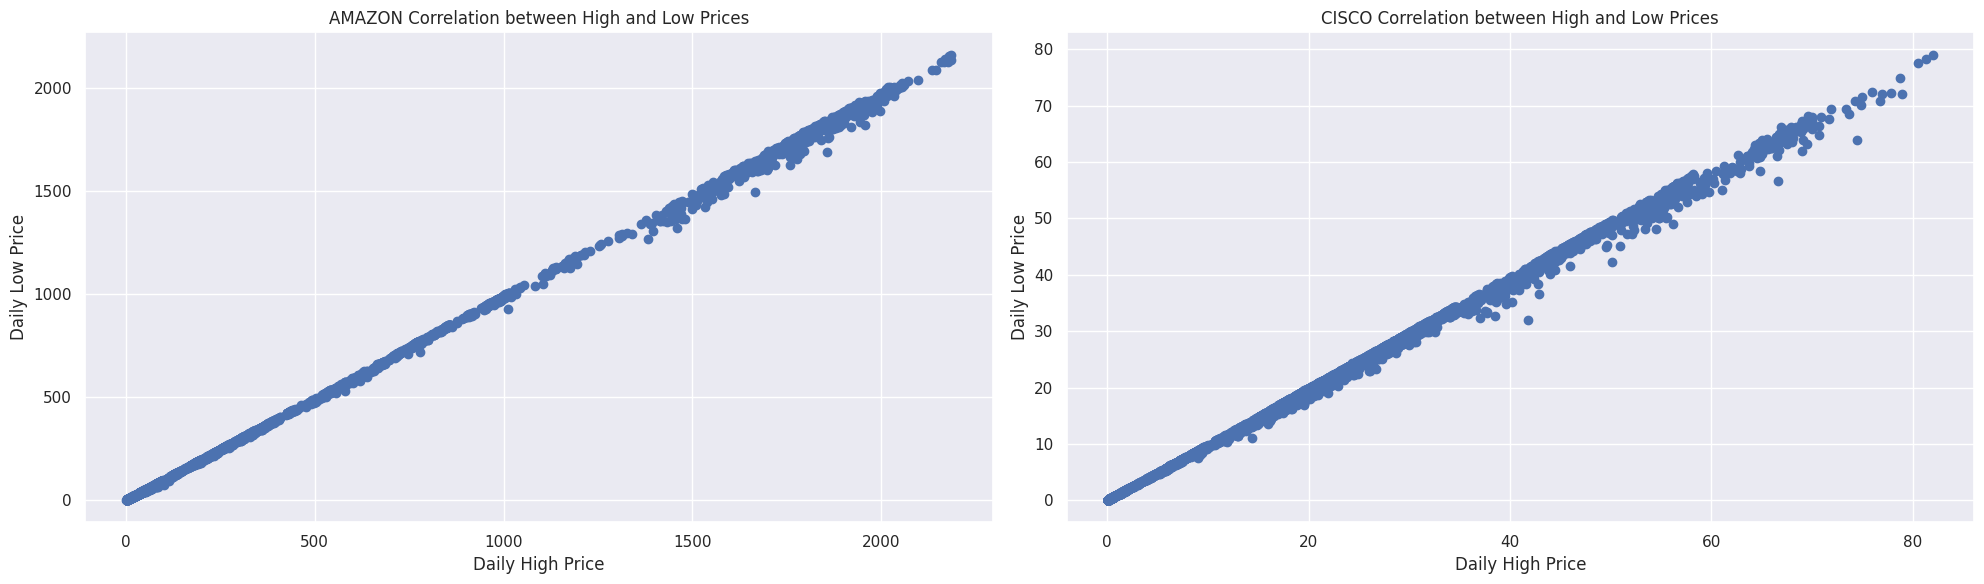

In [ ]:
#check korelasi antara harga jual harian yang tertinggi dan terendah
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.scatter(df['High'], df['Low'])
ax1.set_xlabel('Daily High Price')
ax1.set_ylabel('Daily Low Price')
ax1.set_title('AMAZON Correlation between High and Low Prices')

ax2.scatter(df2['High'], df2['Low'])
ax2.set_xlabel('Daily High Price')
ax2.set_ylabel('Daily Low Price')
ax2.set_title('CISCO Correlation between High and Low Prices')

plt.tight_layout()
plt.show()

Kedua grafik di atas menunjukan korelasi positif yang sama pada masing-masing company, di mana jika harga jual harian tinggi maka harga jual harian juga menurun.

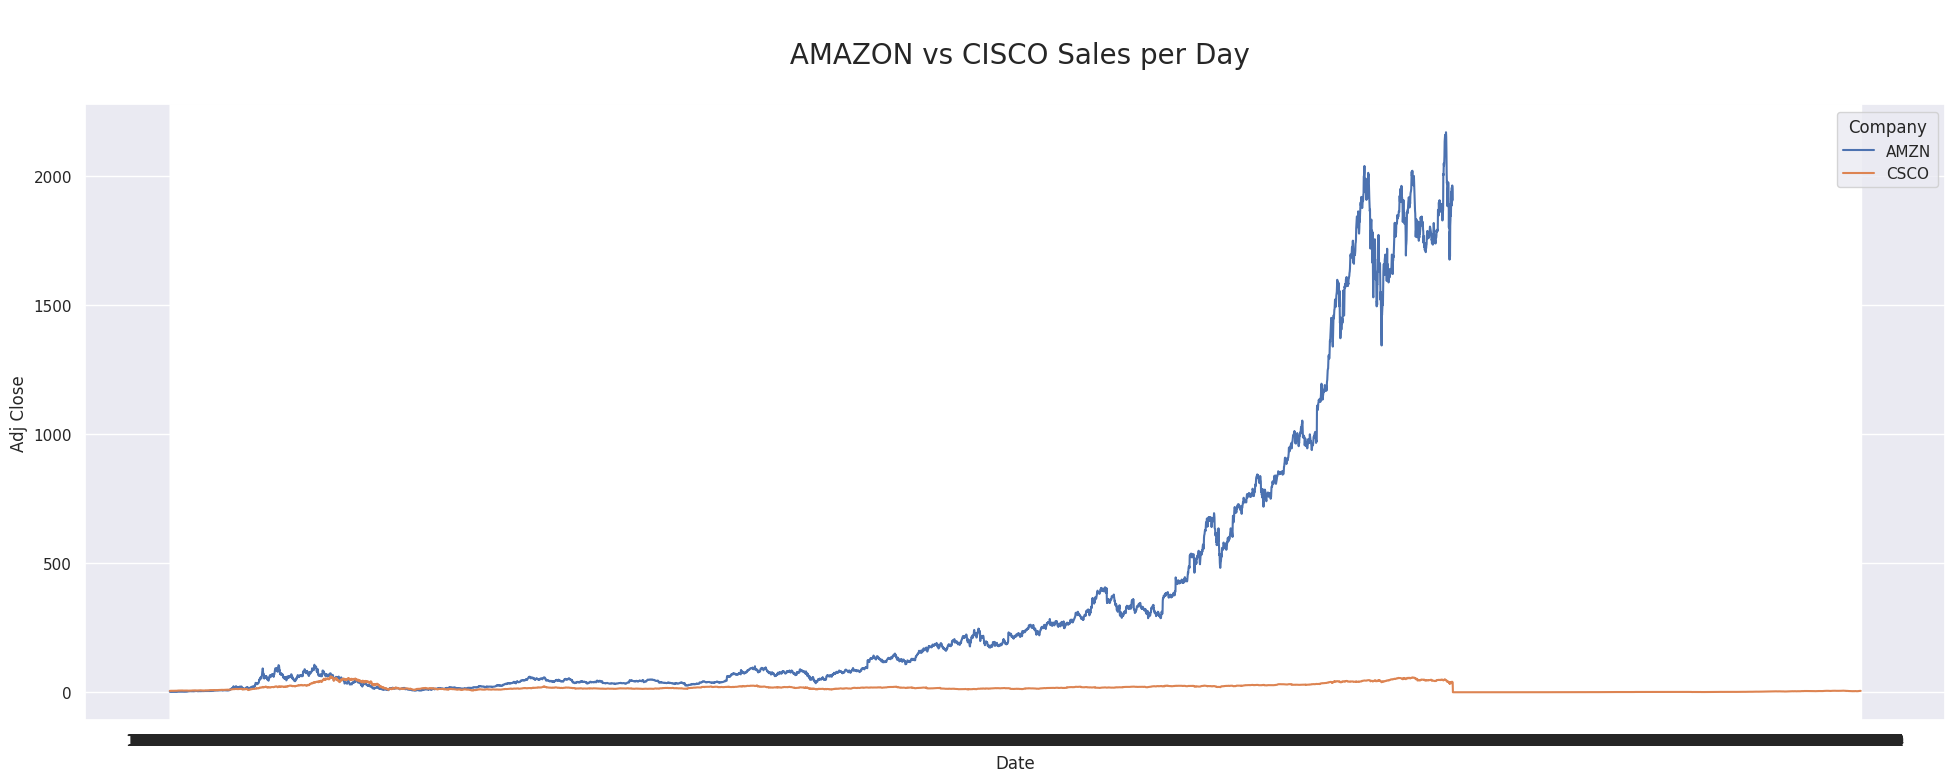

In [ ]:
#komparasi harga penutupan antar 2 company
sns.set(rc={'figure.figsize':(24,8)})
ax=sns.lineplot(data=dfcombine,x='Date',y='Adj Close',hue='Company')
ax.axes.set_title("\n AMAZON vs CISCO Sales per Day\n",fontsize=20);

penjualan stock saham AMAZON kebih diminati dan trendnya pada akhir-akhir ini cukup meningkat pesat. Sedangkan untuk CISCO lumayan stabil, tetapi sempat mengalami sedikit penurunan pembelian.

In [ ]:
#check unique value dari data
print(df.nunique())
print(df2.nunique())

Date         5758
Open         5070
High         5014
Low          5019
Close        5148
Adj Close    5148
Volume       5615
Company         1
dtype: int64
Date         7589
Open         3784
High         3784
Low          3777
Close        3943
Adj Close    5022
Volume       7518
Company         1
dtype: int64


In [ ]:
print("Maximum Close value:", df['Close'].max())
print("Minimum Close value:", df['Close'].min())
print("---------------------------------------")
print("Maximum Close value:", df2['Close'].max())
print("Minimum Close value:", df2['Close'].min())

Maximum Close value: 2170.219970703125
Minimum Close value: 1.3958333730697632
---------------------------------------
Maximum Close value: 80.0625
Minimum Close value: 0.0711805522441864


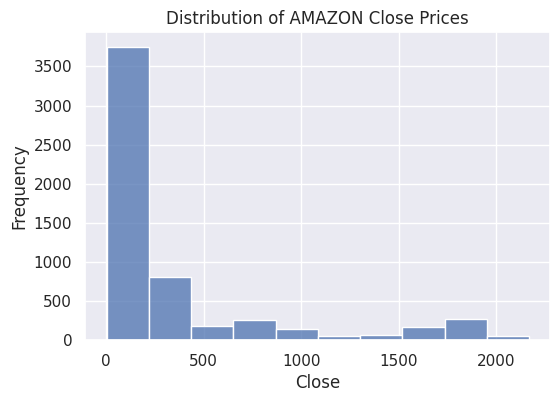

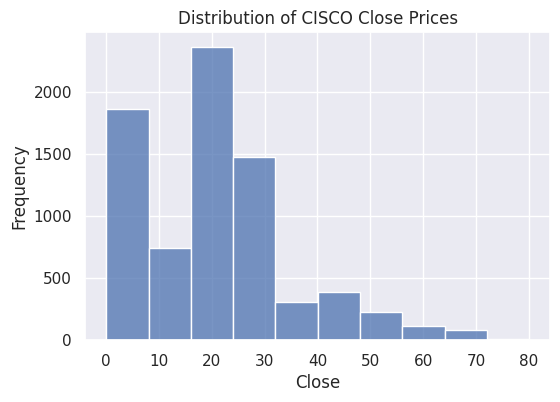

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='Close', bins=10)
plt.title('Distribution of AMAZON Close Prices')
plt.xlabel('Close')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(data=df2, x='Close', bins=10)
plt.title('Distribution of CISCO Close Prices')
plt.xlabel('Close')
plt.ylabel('Frequency')
plt.show()

Dari hasil display value close yang memiliki rentang data besar/pesebaran (pada histogram) tidak seimbang, maka pada pre-processing data saya akan melakukan scaling.

In [ ]:
#cek apakah ada missing value sebelum lanjut ke preprocessing
dfcombine.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Company      0
dtype: int64

In [ ]:
#drop kolom selain Date dan Close, seperti yang diminta oleh soal
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Company'], axis=1)
df2 = df2.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Company'], axis=1)

In [ ]:
#mengubah kolom 'Date' menjadi index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [ ]:
#melakukan windowing
HORIZON = 1  #senin
WINDOW_SIZE = 5  #senin-jumat

def get_labelled_windows(x, horizon=1):
    return x[:, :-horizon], x[:, -horizon:]


#membuat data tensor windowing
test_input = tf.expand_dims(tf.range(6) + 1, axis=0)

#mencoba window
test_window, test_label = get_labelled_windows(test_input, horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5] -> Label: 6


In [ ]:
def make_windows(x, window_size=5, horizon=1):
    #membuat 3d array sequential untuk window_size
    window_indexes = np.arange(len(x) - window_size - horizon + 1)[:, None] + np.arange(window_size + horizon)

    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

#windowing untuk data yang akan digunakan
full_windows, full_labels = make_windows(df['Close'].values, window_size=WINDOW_SIZE, horizon=HORIZON) # Extract the 'Close' column as a NumPy array
print(len(full_windows), len(full_labels))

5753 5753


In [ ]:
#splitting data
def make_train_test_val_splits(windows, labels, train_split=0.8, test_split=0.1, val_split=0.1):
    assert train_split + test_split + val_split == 1, "Splits must sum to 1"

    train_size = int(len(windows) * train_split)
    test_size = int(len(windows) * test_split)
    val_size = len(windows) - train_size - test_size  # Ensure all data is split

    train_windows = windows[:train_size]
    train_labels = labels[:train_size]
    test_windows = windows[train_size:train_size + test_size]
    test_labels = labels[train_size:train_size + test_size]
    val_windows = windows[train_size + test_size:]
    val_labels = labels[train_size + test_size:]

    return train_windows, test_windows, val_windows, train_labels, test_labels, val_labels

#windowing untuk data yang sudah displit
train_windows, test_windows, val_windows, train_labels, test_labels, val_labels = make_train_test_val_splits(full_windows, full_labels)
print(len(train_windows), len(test_windows), len(val_windows), len(train_labels), len(test_labels), len(val_labels))

#mengubah bentuk data agar dapat sesuai dengan input dari model yang akan digunakan, yaitu LSTM
train_windows = np.array(train_windows).reshape((-1, WINDOW_SIZE, 1))
val_windows = np.array(val_windows).reshape((-1, WINDOW_SIZE, 1))
test_windows = np.array(test_windows).reshape((-1, WINDOW_SIZE, 1))

4602 575 576 4602 575 576


In [ ]:
#scaling data
scaler = MinMaxScaler()
train_windows_scaled = scaler.fit_transform(train_windows.reshape(-1, 1)).reshape(-1, WINDOW_SIZE, 1)
val_windows_scaled = scaler.transform(val_windows.reshape(-1, 1)).reshape(-1, WINDOW_SIZE, 1)
test_windows_scaled = scaler.transform(test_windows.reshape(-1, 1)).reshape(-1, WINDOW_SIZE, 1)

In [ ]:
#model base
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(WINDOW_SIZE, 1)))
model_lstm.add(Dense (HORIZON))
model_lstm.compile(loss='mse')
model_lstm.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 50)                10400     
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#model fitting
h1_amzn = model_lstm.fit(train_windows_scaled, train_labels,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_windows_scaled, val_labels))

Epoch 1/20
144/144 [==============================] - 3s 15ms/step - loss: 12439.6006 - val_loss: 2103976.0000
Epoch 2/20
144/144 [==============================] - 1s 7ms/step - loss: 436.9792 - val_loss: 3286542.7500
Epoch 3/20
144/144 [==============================] - 1s 7ms/step - loss: 381.9318 - val_loss: 3069741.5000
Epoch 4/20
144/144 [==============================] - 1s 7ms/step - loss: 351.1733 - val_loss: 2778551.0000
Epoch 5/20
144/144 [==============================] - 1s 7ms/step - loss: 326.3298 - val_loss: 1740438.1250
Epoch 6/20
144/144 [==============================] - 1s 7ms/step - loss: 297.5382 - val_loss: 1700476.3750
Epoch 7/20
144/144 [==============================] - 1s 7ms/step - loss: 270.1390 - val_loss: 949923.1250
Epoch 8/20
144/144 [==============================] - 1s 7ms/step - loss: 219.0257 - val_loss: 440773.5000
Epoch 9/20
144/144 [==============================] - 1s 7ms/step - loss: 168.8171 - val_loss: 490946.2188
Epoch 10/20
144/144 [=======

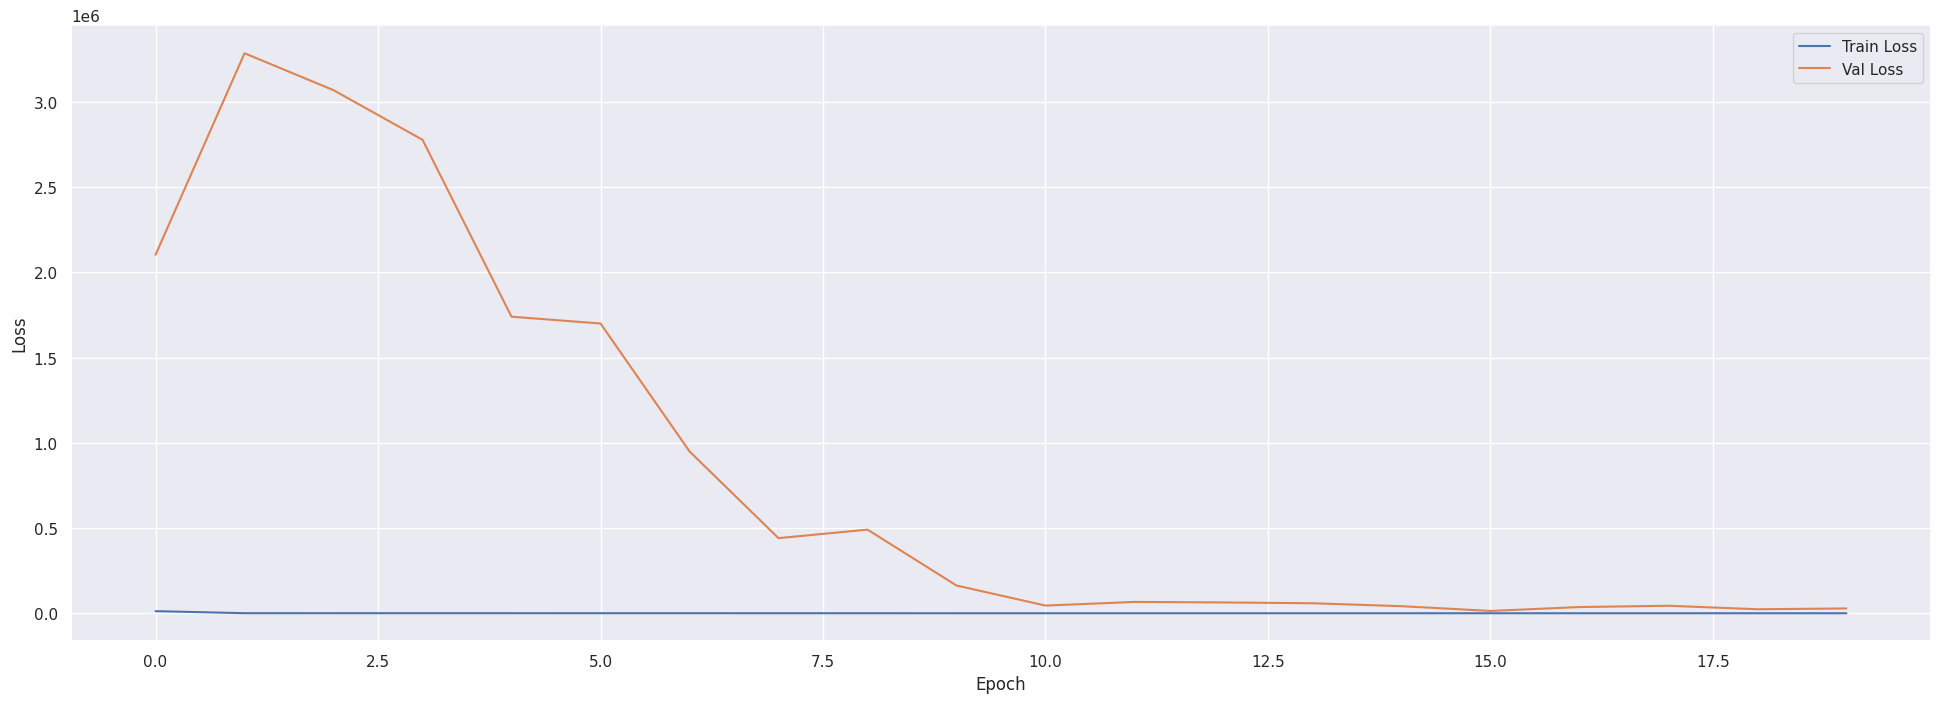

In [ ]:
train_loss = h1_amzn.history['loss']
val_loss = h1_amzn.history['val_loss']

# plot data yang sudah di training
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

meskipun nilai val loss sangat tinggi di awal epoch, tetapi dapat menjadi model yang baik (garis orange menurun) dalam memprediksi dengan bertambahnya epoch.

In [ ]:
#data testing
predictions = model_lstm.predict(test_windows)
predictions = scaler.inverse_transform(predictions)

18/18 [==============================] - 0s 2ms/step


In [ ]:
y_true = test_labels

#evaluasi menggunakan metrics: rsme, mae, dan mape:
rmse = np.sqrt(np.mean((predictions.flatten() - y_true) ** 2))  #data yang ada di flatten untuk hasil yang lebih konsisten
mae = np.mean(np.abs(predictions.flatten() - y_true))
mape = np.mean(np.abs((predictions.flatten() - y_true) / y_true)) * 100

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 184686157.95953938
MAE: 180732871.06850415
MAPE: 23815969.865071498


Modified Model AMAZON


dalam model ini saya menambahkan:
1. optimizer adam dengan learning rate = 0.0001 agar saat data training tetap stabil.
2. callbacks:
- early stopping untuk menghentikan training bila nilai val-loss selama 5 epoch tidak berubah
- reduce learning rate untuk memastikan jika dan nilai learning rate dari 0.0001 selama 5 epoch maka lr akan dikurangi setengahnya.
3. menambahkan layer agar model dalam menangkap pola yang lebih kompleks
4. dropout, mengurangi neuron sebanyak 30% untuk mencegah overfitting
5. menambahkan aktivasi tanh yang mana lebih sensitif dalam menangkap pola yang kompleks dibandingkan dengan relu.
6. pada output layer memakai akativasi linear yang cocok dengan proyek dengan nilai kontinu, seperti proyek regresi: stock.
5. menambah batch size untuk konvergensi, kestabilan gradien dari hasil training.

In [ ]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model_lstm2  = Sequential()
model_lstm2.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model_lstm2.add(LSTM(64, activation='relu', return_sequences=True))
model_lstm2.add(LSTM(128, activation='relu', return_sequences=True))
model_lstm2.add(Dropout(0.3))
model_lstm2.add(LSTM(32, activation='relu', return_sequences=False))
model_lstm2.add(Dropout(0.3))
model_lstm2.add(Dense(HORIZON, activation = "linear"))


model_lstm2.compile(loss='mse', optimizer=optimizer)
model_lstm2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 5, 256)            264192    
                                                                 
 lstm_47 (LSTM)              (None, 5, 64)             82176     
                                                                 
 lstm_48 (LSTM)              (None, 5, 128)            98816     
                                                                 
 dropout_22 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_49 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 1)               

In [ ]:
#model fitting dengan data training dan validasi
history_amzn = model_lstm2.fit(train_windows_scaled, train_labels,
               batch_size=64,
               epochs=50,
               validation_data=(val_windows_scaled, val_labels),
               callbacks = [early_stopping, reduce_lr])

Epoch 1/50
72/72 [==============================] - 7s 35ms/step - loss: 25293.3496 - val_loss: 3030682.2500 - lr: 1.0000e-04
Epoch 2/50
72/72 [==============================] - 2s 30ms/step - loss: 24976.9473 - val_loss: 621153.1250 - lr: 1.0000e-04
Epoch 3/50
72/72 [==============================] - 2s 28ms/step - loss: 4746.6997 - val_loss: 17814752.0000 - lr: 1.0000e-04
Epoch 4/50
72/72 [==============================] - 2s 27ms/step - loss: 1563.1721 - val_loss: 14866310.0000 - lr: 1.0000e-04
Epoch 5/50
72/72 [==============================] - 2s 28ms/step - loss: 1454.3932 - val_loss: 15482348.0000 - lr: 1.0000e-04
Epoch 6/50
72/72 [==============================] - 2s 27ms/step - loss: 1380.2867 - val_loss: 15385234.0000 - lr: 1.0000e-04
Epoch 7/50
72/72 [==============================] - 2s 26ms/step - loss: 1255.6228 - val_loss: 14568157.0000 - lr: 1.0000e-04


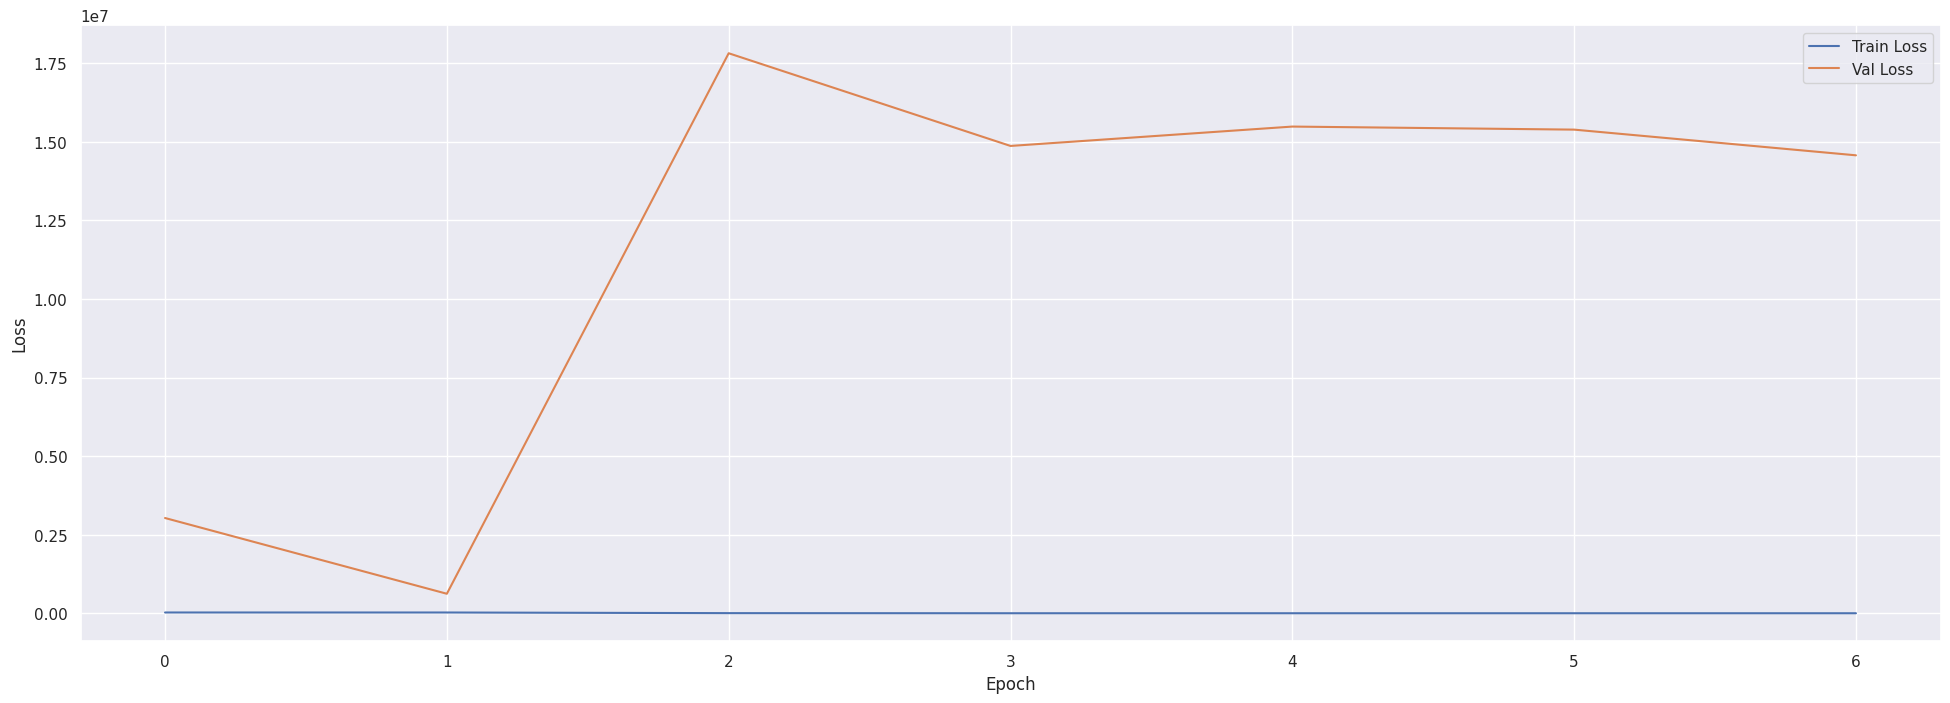

In [ ]:
train_loss = history_amzn.history['loss']
val_loss = history_amzn.history['val_loss']

#visualisasi hasil training moel 2
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

model tersebut sangat overfitting, untuk penanganannya dapat dilakukan epoch yang lebih atau mengurangi layer karena dapat menyebabkan tingkat kompleksitas yang tinggi dan memicu overfitting pada model.

In [ ]:
predictions2 = model_lstm2.predict(test_windows)
predictions2 = scaler.inverse_transform(predictions2)

18/18 [==============================] - 1s 5ms/step


In [ ]:
y_true = test_labels

#evaluasi metrics
rmse = np.sqrt(np.mean((predictions2.flatten() - y_true) ** 2))
mae = np.mean(np.abs(predictions2.flatten() - y_true))
mape = np.mean(np.abs((predictions2.flatten() - y_true) / y_true)) * 100

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 1068219244.7423068
MAE: 1044713642.5328518
MAPE: 137666514.88995418


Kesimpulan:

Jika membandingan hasil metrics evaluasi dan nilai loss dari kedua model AMAZON, model setelah dimodifikasi menunjukan hasil yang jauh lebih buruk dibandingkan model base.

- model sebelum modif memiliki angka loss dan validation loss yang lebih besar dibandingkan model kedua. Hal tersebut bisa dikarenakan kompleksitas model dan dapat diatasi dengan mengurangi layer dan menambahkan epoch.

- RMSE (m1: 0.04747286493322133 dan m2: 0.RMSE: 1068219244.7423068)
> mengindikkasi rata-rata deviasi dari kesalahan model prediksi dengan data yang sebenarnya.

- MAE (m1: 0.038036255982022885 - m2: 1044713642.5328518)
> rata-rata kesalahan absolut dari hasil prediksi.

- MAPE (m1: 11.042369389618917 - m2: 137666514.88995418)
> rata-rata relatif terhadap nilai yang sebenarnya.

Maka dari itu, model 1 memiliki performa yang lebih baik di mana angka rmse, mape dan mae yang dihasilkan lebih rendah. model pertama tidak menunjukan adanya kesulitan dan overfitting dalam memprediksi.

# **CISCO**

In [ ]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)

In [ ]:
df2 = scaler.fit_transform(df2.values.reshape(-1, 1))

In [ ]:
full_windows, full_labels = make_windows(df2, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(7584, 7584)

In [ ]:
def make_train_test_val_splits(windows, labels, train_split=0.8, test_split=0.1, val_split=0.1):
    assert train_split + test_split + val_split == 1, "Splits must sum to 1"

    train_size = int(len(windows) * train_split)
    test_size = int(len(windows) * test_split)
    val_size = len(windows) - train_size - test_size

    train_windows = windows[:train_size]
    train_labels = labels[:train_size]
    test_windows = windows[train_size:train_size + test_size]
    test_labels = labels[train_size:train_size + test_size]
    val_windows = windows[train_size + test_size:]
    val_labels = labels[train_size + test_size:]

    return train_windows, test_windows, val_windows, train_labels, test_labels, val_labels

train_windows, test_windows, val_windows, train_labels, test_labels, val_labels = make_train_test_val_splits(full_windows, full_labels)
print(len(train_windows), len(test_windows), len(val_windows), len(train_labels), len(test_labels), len(val_labels))

train_windows = np.array(train_windows).reshape((-1, WINDOW_SIZE, 1))
val_windows = np.array(val_windows).reshape((-1, WINDOW_SIZE, 1))
test_windows = np.array(test_windows).reshape((-1, WINDOW_SIZE, 1))

6067 758 759 6067 758 759


In [ ]:
scaler = MinMaxScaler()
train_windows_scaled = scaler.fit_transform(train_windows.reshape(-1, 1)).reshape(-1, WINDOW_SIZE, 1)
val_windows_scaled = scaler.transform(val_windows.reshape(-1, 1)).reshape(-1, WINDOW_SIZE, 1)
test_windows_scaled = scaler.transform(test_windows.reshape(-1, 1)).reshape(-1, WINDOW_SIZE, 1)

In [ ]:
lstm_csco = Sequential()
lstm_csco.add(LSTM(50, activation='relu', input_shape=(WINDOW_SIZE, 1)))
lstm_csco.add(Dense(HORIZON))
lstm_csco.compile(loss='mse')
lstm_csco.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 50)                10400     
                                                                 
 dense_24 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#model fitting
history_csco = lstm_csco.fit(train_windows_scaled, train_labels,
               batch_size=32,
               epochs=20,
               validation_data=(val_windows_scaled, val_labels))

Epoch 1/20
190/190 [==============================] - 3s 8ms/step - loss: 0.0097 - val_loss: 1.7114e-04
Epoch 2/20
190/190 [==============================] - 1s 7ms/step - loss: 1.6060e-04 - val_loss: 1.4627e-04
Epoch 3/20
190/190 [==============================] - 1s 7ms/step - loss: 1.5784e-04 - val_loss: 1.4376e-04
Epoch 4/20
190/190 [==============================] - 1s 7ms/step - loss: 1.5245e-04 - val_loss: 3.3419e-04
Epoch 5/20
190/190 [==============================] - 1s 7ms/step - loss: 1.5567e-04 - val_loss: 1.6502e-04
Epoch 6/20
190/190 [==============================] - 1s 7ms/step - loss: 1.5021e-04 - val_loss: 1.6362e-04
Epoch 7/20
190/190 [==============================] - 1s 7ms/step - loss: 1.4971e-04 - val_loss: 1.5678e-04
Epoch 8/20
190/190 [==============================] - 1s 7ms/step - loss: 1.4603e-04 - val_loss: 8.1972e-04
Epoch 9/20
190/190 [==============================] - 1s 7ms/step - loss: 1.4559e-04 - val_loss: 2.3501e-04
Epoch 10/20
190/190 [===========

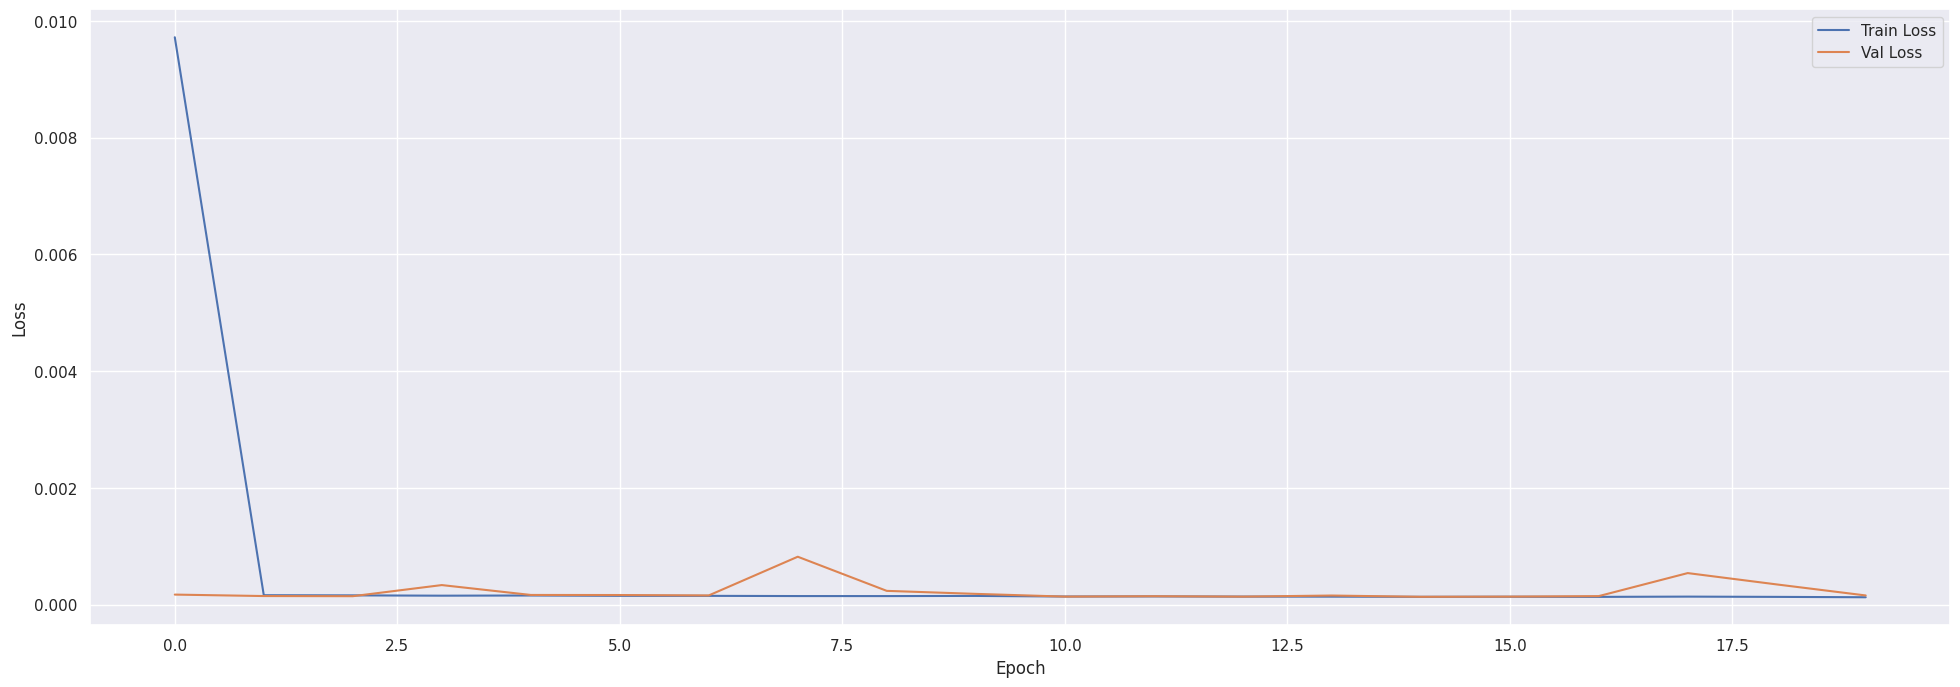

In [ ]:
train_loss = history_csco.history['loss']
val_loss = history_csco.history['val_loss']

#plot hasil training model 1
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Jika melihat grafik di atas, terlihat bahwa meskipun val loss sempat mengalami sedikit kenaikan (ciri overfitting) dalam beberapa interval epoch, tetapi model 1 masih tetap dapat menanganinya sehingga model tidak menjadi overfitting.

In [ ]:
prediction_csco = lstm_csco.predict(test_windows)
prediction_csco = scaler.inverse_transform(prediction_csco)

24/24 [==============================] - 0s 2ms/step


In [ ]:
y_true = test_labels

#evaluasi metrics
rmse = np.sqrt(np.mean((prediction_csco.flatten() - y_true) ** 2))
mae = np.mean(np.abs(prediction_csco.flatten() - y_true))
mape = np.mean(np.abs((prediction_csco.flatten() - y_true) / y_true)) * 100

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 0.04747286493322133
MAE: 0.038036255982022885
MAPE: 11.042369389618917


dalam model ini saya menambahkan:
1. optimizer adam dengan learning rate = 0.0001 agar saat data training tetap stabil.
2. callbacks:
- early stopping untuk menghentikan training bila nilai val-loss selama 5 epoch tidak berubah
- reduce learning rate untuk memastikan jika dan nilai learning rate dari 0.0001 selama 5 epoch maka lr akan dikurangi setengahnya.
3. menambahkan layer agar model dalam menangkap pola yang lebih kompleks
4. dropout, mengurangi neuron sebanyak 20% untuk mencegah overfitting
5. menambahkan aktivasi tanh yang mana lebih sensitif dalam menangkap pola yang kompleks dibandingkan dengan relu.
6. pada output layer memakai akativasi linear yang cocok dengan proyek dengan nilai kontinu, seperti proyek regresi: stock.
5. menambah batch size untuk konvergensi, kestabilan gradien dari hasil training.

In [ ]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

lstm_csco2  = Sequential()
lstm_csco2.add(LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
lstm_csco2.add(Dropout(0.2))
lstm_csco2.add(LSTM(64, activation= 'relu', return_sequences=True))
lstm_csco2.add(Dropout(0.2))
lstm_csco2.add(LSTM(32, activation='relu', return_sequences=False))
lstm_csco2.add(Dense(HORIZON, activation = "linear"))


lstm_csco2.compile(loss='mse', optimizer=optimizer)
lstm_csco2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 5, 128)            66560     
                                                                 
 dropout_26 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_55 (LSTM)              (None, 5, 64)             49408     
                                                                 
 dropout_27 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_56 (LSTM)              (None, 32)                12416     
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 128417 (501.63 KB)
Trainable params: 12

In [ ]:
history_csco2 = lstm_csco2.fit(train_windows_scaled,
                               train_labels,
                               batch_size=100,
                               epochs=50,
                               validation_data=(val_windows_scaled, val_labels),
                               callbacks = [early_stopping])

Epoch 1/50
61/61 [==============================] - 6s 27ms/step - loss: 0.0574 - val_loss: 0.1984
Epoch 2/50
61/61 [==============================] - 1s 17ms/step - loss: 0.0236 - val_loss: 0.0253
Epoch 3/50
61/61 [==============================] - 1s 17ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 4/50
61/61 [==============================] - 1s 17ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/50
61/61 [==============================] - 1s 17ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/50
61/61 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/50
61/61 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 9.3540e-04
Epoch 8/50
61/61 [==============================] - 1s 17ms/step - loss: 9.2657e-04 - val_loss: 7.1419e-04
Epoch 9/50
61/61 [==============================] - 1s 18ms/step - loss: 7.6462e-04 - val_loss: 7.5378e-04
Epoch 10/50
61/61 [==============================] - 1s 18ms/step - loss: 5.3829e-04 - va

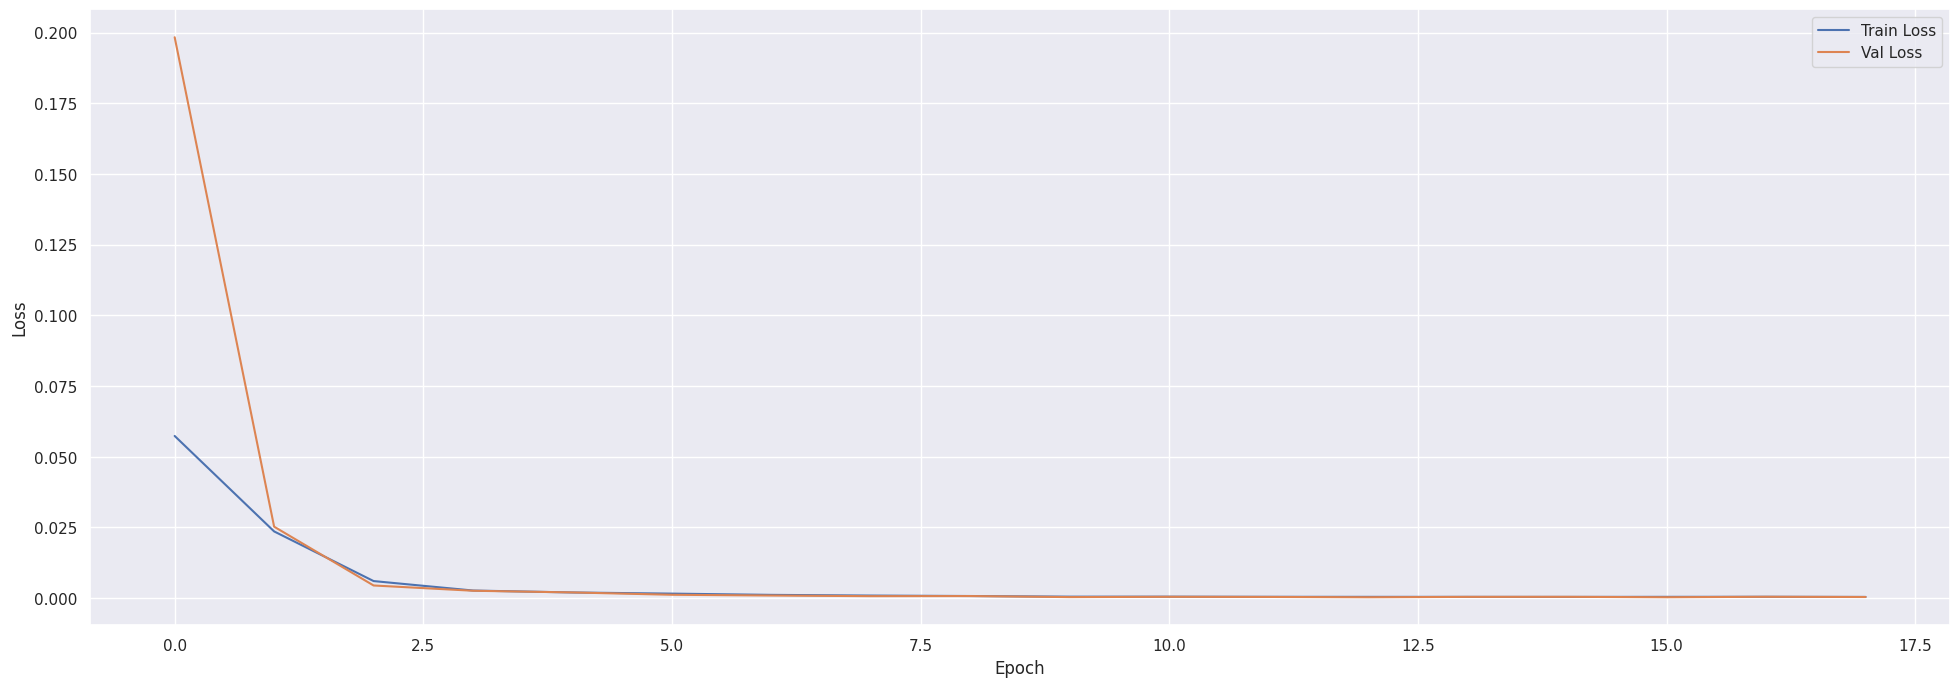

In [ ]:
train_loss = history_csco2.history['loss']
val_loss = history_csco2.history['val_loss']

#plot hasil training model 2
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Validation loss dan training loss semakin mendekat dan menjadi linear yang mana menunjukan bahwa model 2  sudah memprediksi dengan baik.

In [ ]:
prediction_csco2 = lstm_csco2.predict(test_windows)
prediction_csco2 = scaler.inverse_transform(prediction_csco2)

24/24 [==============================] - 1s 4ms/step


In [ ]:
y_true = test_labels

#metrics evaluasi
rmse = np.sqrt(np.mean((prediction_csco2.flatten() - y_true) ** 2))  # Flatten predictions for consistency
mae = np.mean(np.abs(prediction_csco2.flatten() - y_true))
mape = np.mean(np.abs((prediction_csco2.flatten() - y_true) / y_true)) * 100  # Handle potential division by zero

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 0.04557389583061953
MAE: 0.03650562302427697
MAPE: 10.625274492891917


Kesimpulan:

Jika membandingan hasil metrics evaluasi dan nilai loss dari kedua model CISCO, model setelah dimodifikasi menunjukan hasil yang lebih baik, meskipun tidak terlihat adanya peningkatan yang signifikan.

- model sebelum modif memiliki angka loss dan validation loss yang lebih kecil dibandingkan model kedua. Tetapi, perbedaan diantaranya jika dibandingkan oleh nilai dari model kedua lebih besar. Maka dari itu metrics yang dihasilkan oleh model kedua lebih baik.

- RMSE (m1: 0.04747286493322133 dan m2: 0.04557389583061953)
> mengindikkasi rata-rata deviasi dari kesalahan model prediksi dengan data yang sebenarnya.

- MAE (m1: 0.038036255982022885 - m2: 0.03650562302427697)
> rata-rata kesalahan absolut dari hasil prediksi.

- MAPE (m1: 11.042369389618917 - m2: 10.625274492891917)
> rata-rata relatif terhadap nilai yang sebenarnya.

Maka dari itu, model 2 memiliki performa yang lebih baik di mana angka rmse dan mae yang dihasilkan lebih rendah, serta pada mape nilai aktual pada data memang sudah kecil sehingga hasil evaluasinya tidak menjadi signifikan.